DSCI Group Project Proposal (Group 89: Ava Alexander, Fangzhou Ye, Maya Seethram)

Predictive Question: Can we predict whether or not a class completed a test preparation course based on their test results?


INTRODUCTION

Are high marks in school a result of hardwork and effort, or simply a result of natural intelligence? There always seem to be students who achieve high grades without having studied all semester. We want to explore whether success in exams can be achieved by natural intelligence alone, or whether hard work and studying is necessary to succeed.

We would like to try to predict the following question: Can we use the academic test scores available to us to predict whether a student has completed a test preparation course prior to their test?


We will be using a dataset of student exam scores at public schools. The dataset provides data for whether or not the student completed a test preparation course prior to the test, as well as their math, reading, and writing scores from the test. We will use this data to explore the relation between exam scores and preparation taken. 


PRELIMINARY EXPLORATORY DATA ANALYSIS

First, we loaded the tidyverse and tidymodels packages 

In [18]:
library(tidyverse)
library(tidymodels)
library(gridExtra)
library(themis)


Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine




ERROR: Error in library(themis): there is no package called ‘themis’


We loaded our dataset "exams" as a .csv file using the read_csv function and saved it to the object exam_data

In [13]:
#Read data
exam_data <- read_csv("exams.csv")
head(exam_data)
#Change the col name
colnames(exam_data) <- make.names(colnames(exam_data))
head(exam_data)

Rows: 1000 Columns: 8
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (5): gender, race/ethnicity, parental level of education, lunch, test pr...
dbl (3): math score, reading score, writing score

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
male,group A,high school,standard,completed,67,67,63
female,group D,some high school,free/reduced,none,40,59,55
male,group E,some college,free/reduced,none,59,60,50
male,group B,high school,standard,none,77,78,68
male,group E,associate's degree,standard,completed,78,73,68
female,group D,high school,standard,none,63,77,76


gender,race.ethnicity,parental.level.of.education,lunch,test.preparation.course,math.score,reading.score,writing.score
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
male,group A,high school,standard,completed,67,67,63
female,group D,some high school,free/reduced,none,40,59,55
male,group E,some college,free/reduced,none,59,60,50
male,group B,high school,standard,none,77,78,68
male,group E,associate's degree,standard,completed,78,73,68
female,group D,high school,standard,none,63,77,76


We replaced the spaces in the column names using the make.names function so that we can use the tidyverse functions

We mutated the exam data and selected for the columns we will use.

In [14]:
#Make the test.preparation.course 0 and 1 then as factor
exam <- exam_data |>
mutate(test.preparation.course = ifelse(test.preparation.course == "completed", 1, 0)) |>
mutate(test.preparation.course = as_factor(test.preparation.course)) |>
select(test.preparation.course, math.score, reading.score, writing.score)
head(exam)


test.preparation.course,math.score,reading.score,writing.score
<fct>,<dbl>,<dbl>,<dbl>
1,67,67,63
0,40,59,55
0,59,60,50
0,77,78,68
1,78,73,68
0,63,77,76


We made box plots to show the student's score range for each subject (math, writing, reading)

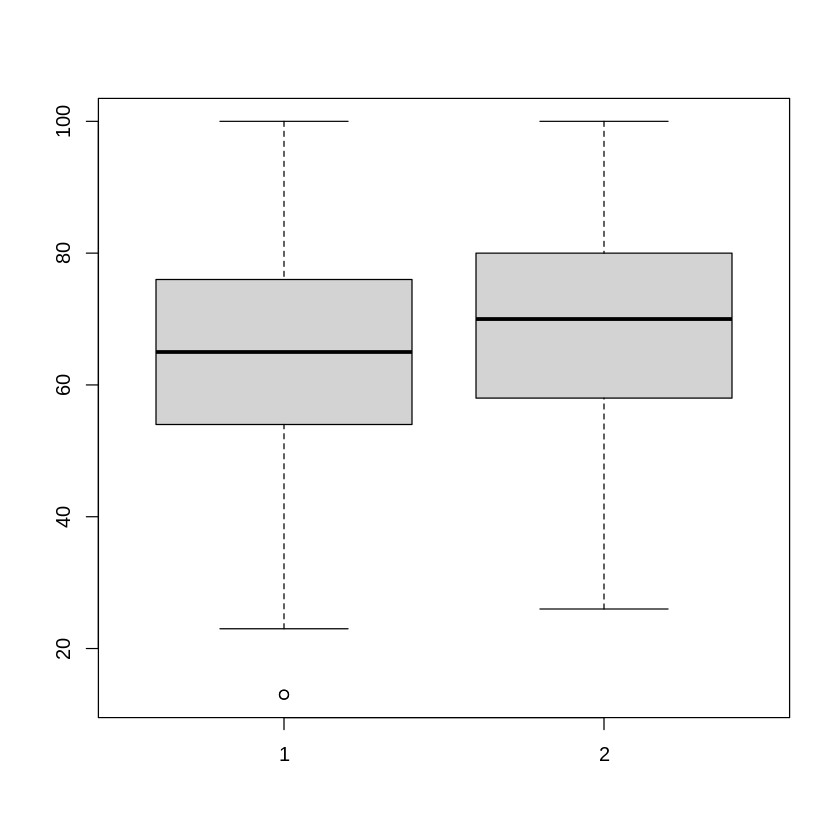

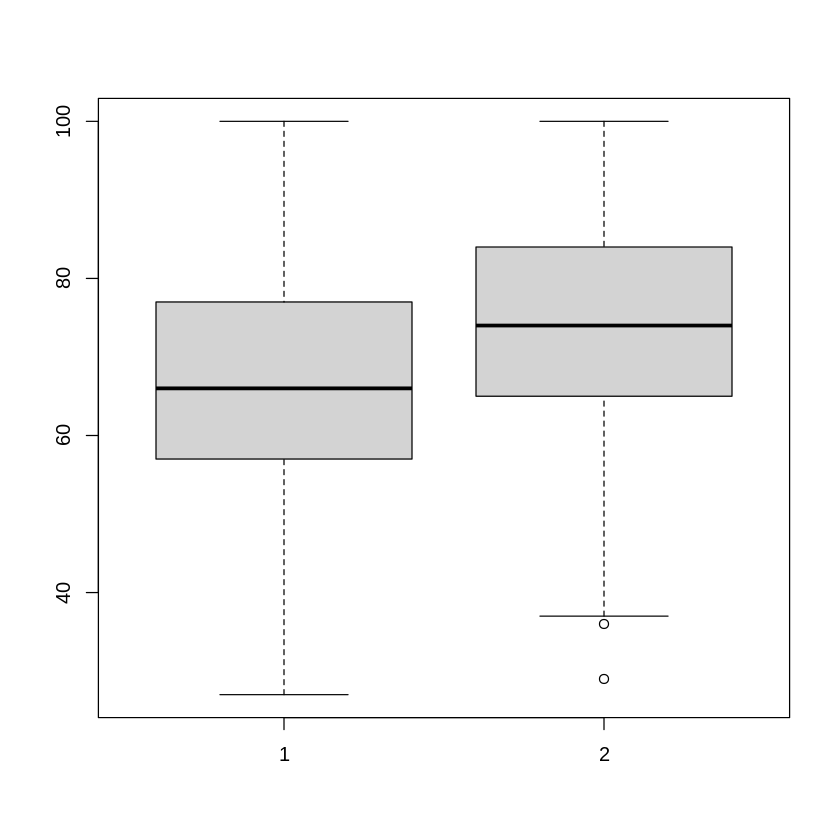

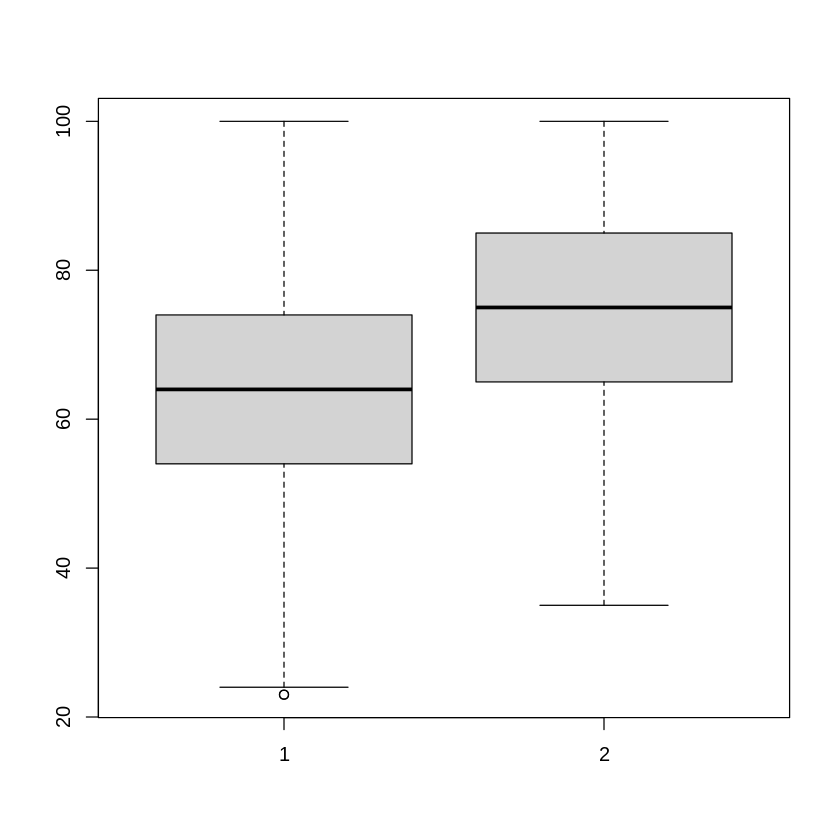

In [15]:
#Show box plot
exam_0 <- exam |> filter(test.preparation.course==0)
exam_1 <- exam |> filter(test.preparation.course==1)
boxplot(exam_0$math.score,exam_1$math.score)
boxplot(exam_0$reading.score,exam_1$reading.score)
boxplot(exam_0$writing.score,exam_1$writing.score)


In [16]:
#Start train data
exam_split <- initial_split(exam, prop = 0.75, strata = test.preparation.course)
exam_training <- training(exam_split)
exam_testing <- testing(exam_split)

exam_proportions <- exam_training |>
                      group_by(test.preparation.course) |>
                      summarize(n = n()) |>
                      mutate(percent = 100*n/nrow(exam_training))
exam_proportions

           

test.preparation.course,n,percent
<fct>,<int>,<dbl>
0,498,66.48865
1,251,33.51135


We then made three scatter plots showing the relationship between each of the predictive variables (math score, writing score, reading score).  We colored the points depending on whether or not the student completed the preparatory course (0 = did not complete, 1 = completed).

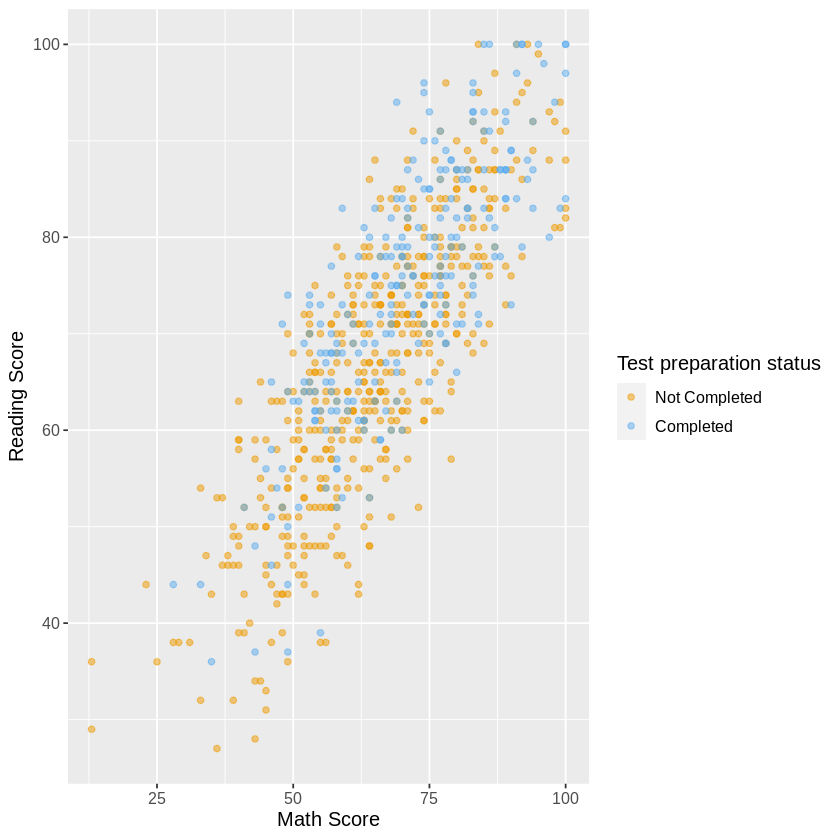

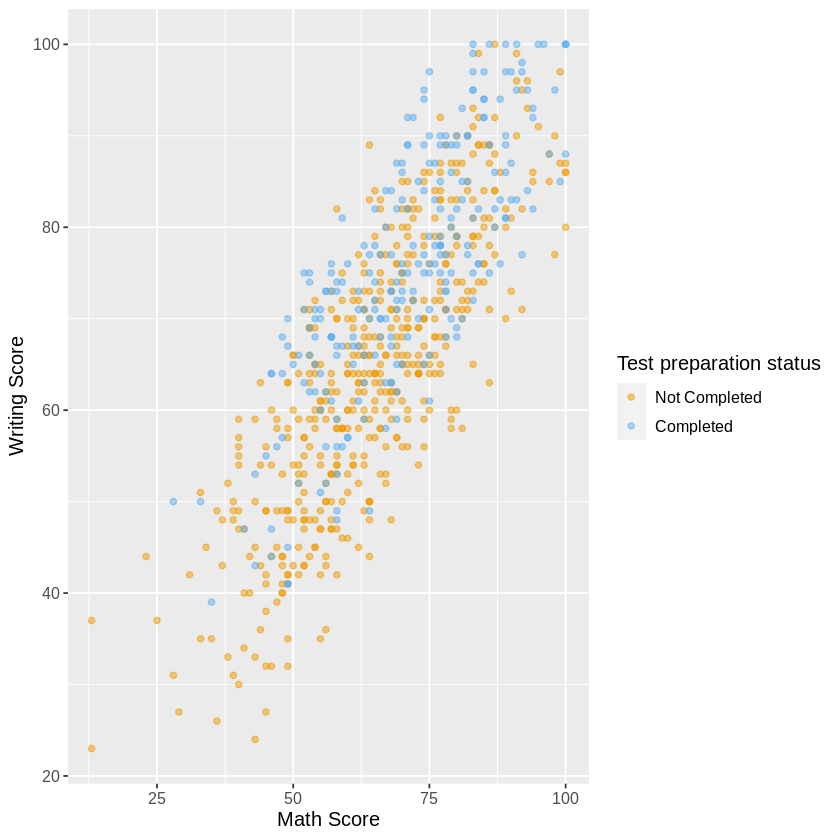

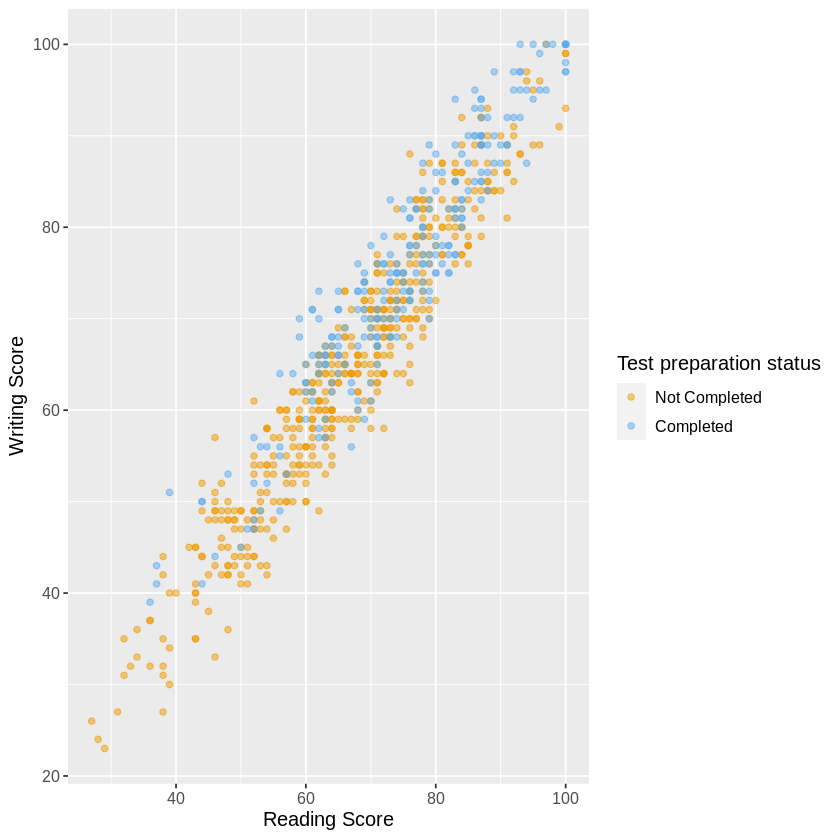

In [20]:
exam_plot1 <- exam_training |>
  ggplot(aes(x = math.score, y = reading.score, color = test.preparation.course)) +
  geom_point(alpha = 0.5) +
  labs(x = "Math Score", 
       y = "Reading Score",
       color = "Test preparation status") +
scale_color_manual(labels = c("Not Completed", "Completed"), 
                     values = c("orange2", "steelblue2")) + 
  theme(text = element_text(size = 12))
exam_plot1


exam_plot2 <- exam_training |>
  ggplot(aes(x = math.score, y = writing.score, color = test.preparation.course)) +
  geom_point(alpha = 0.5) +
  labs(x = "Math Score", 
       y = "Writing Score",
       color = "Test preparation status") +
scale_color_manual(labels = c("Not Completed", "Completed"), 
                     values = c("orange2", "steelblue2")) + 
  theme(text = element_text(size = 12))
exam_plot2



exam_plot3 <- exam_training |>
  ggplot(aes(x = reading.score, y = writing.score, color = test.preparation.course)) +
  geom_point(alpha = 0.5) +
  labs(x = "Reading Score", 
       y = "Writing Score",
       color = "Test preparation status") +
scale_color_manual(labels = c("Not Completed", "Completed"), 
                     values = c("orange2", "steelblue2")) + 
  theme(text = element_text(size = 12))
exam_plot3



METHODS

We will select “test.preparation.course” column and the three test score columns (“math score”, “reading score”, “writing score”).   These are the only columns we will be using from the data set to answer our predictive question.   Using these three, we will train a K-nearest neighbor classifier to classify whether a student did or did not complete their test preparation course judging from their test scores (i.e. the test scores are the response variables).  To perform the K-nearest neighbor classification, we will:
1. choose an appropriate K value
2. select our predictor values (all three scores)
3. train our model 
4. scale and center data (if necessary)
4. finally, we will test the accuracy of our model



EXPECTED OUTCOMES AND SIGNIFICANCE

We expect to find that the ability does exist to predict whether or not a student has prepared for the test preparation course by their test results. The score that a student receives is a direct indication of whether or not they have prepared well by completing the test preparation course or not. We expect to find that if a student has completed the course, they have a high test score, but if they have not then their test score is more likely to be low.


These findings could show the importance of proper preparation for exams, and the impact that test preparation can have on test scores.


This could lead to future questions regarding the need for preparation prior to exams. An example could be: Can we predict how many hours a student has studied by their test results? Another stream of questioning could be: How many hours of preparation does it take to make a significant increase in an individual’s test scores?
